# [DeepLearning] [3] 파이토치 - 파이토치 신경망 구현 (1)

보편적인 함수 $f$의 근사함수 $F$의 모델을 $ F(\{v_i\}, \{\textbf{w}_i\}, \{b_i\}; \textbf{x}) = \sum_{i=1}^{N} v_{i}\varphi(\textbf{x} \cdot \textbf{w}_{i} + b_{i})$ 로 세우고 학습을 진행해보겠습니다. 학습용 데이터셋을 $\textbf{x}$와 $\textbf{x}$에 대응되는 truth 데이터 $f(\textbf{x})$의 데이터 쌍들로 구성한 후, 경사하강법을 이용하여 적절한 모델 파라미터 $\{v_i\}, \{w_i\}, \{b_i\}$ 를 구함으로써 보편적인 수학적 함수 $f$의 근사함수를 학습시킬 수 있습니다. $f(x)=cos(x), x \in [-2\pi, 2\pi]$의 근사함수를 구해보겠습니다.

In [35]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

## 1. 모델(클래스) 정의하기

### 1.1. 순전파

근사함수 $F(x)$의 형태를 모델(클래스)로 정의해보겠습니다.

In [36]:
class Model(torch.nn.Module):
    def initialize_params(self, N: int):
        self.w = torch.nn.Parameter(torch.randn(1,N))
        self.b = torch.nn.Parameter(torch.randn(1,N))
        self.v = torch.nn.Parameter(torch.randn(N,1))

    def __init__(self, num_neurons: int):
        super(Model, self).__init__()
        self.initialize_params(num_neurons)

    def forward(self, x):
        out1 = torch.sigmoid(torch.matmul(x, self.w) + self.b)
        return torch.matmul(out1, self.v)

    @property
    def model_parameters(self):
        return (self.w, self.b, self.v)

    def load_parameters(self, w, b, v):
        self.w = torch.nn.Parameter(w)
        self.b = torch.nn.Parameter(b)
        self.v = torch.nn.Parameter(v)

### 1.2. 손실 함수

실제값과 예측값의 차이를 제곱한 MSE 손실 함수를 작성해보겠습니다.

In [37]:
def loss_func(pred, true):
  mse = torch.mean((pred-true)**2)
  return mse

### 1.3. 역전파

모델 파라미터에 해당하는 텐서들과 학습률을 매개변수로 받아 경사하강법을 진행하는 함수를 작성해보겠습니다.

In [38]:
def gradient_step(tensors, learning_rate):
  if isinstance(tensors, torch.Tensor):
    tensors = [tensors]

  for t in tensors:
    if t.grad is not None:
      t.data -= learning_rate * t.grad

## 2. 모델 학습

### 2.1. 순전파와 역전파의 반복

구간 $[-2\pi, 2\pi]$에서 근사함수를 구할 것이기 때문에, 구간 $[-2\pi, 2\pi]$를 균등하게 1000개 정도의 구간으로 나눈 배열을 입력되는 $x$데이터(train_data)로 사용하겠습니다.

In [39]:
train_data = np.linspace(-2*np.pi, 2*np.pi, 1000).reshape(1000,1)

$cos$ 연산을 적용하는 함수를 true_f로 정의한 후, truth_data 배열을 true_f에 통과하여 얻어진 배열을 truth 데이터로 사용하겠습니다.

In [40]:
def true_f(x):
  return np.cos(x)

위에서 작성한 Model 클래스를 이용하여 객체를 생성하겠습니다. 하이퍼파라미터인 뉴런 개수는 10개로 해보겠습니다.

In [41]:
model = Model(num_neurons = 10)

train 데이터셋을 텐서로 정의하겠습니다.

In [42]:
train_data_tensor = torch.tensor(train_data, dtype = torch.float32)

In [43]:
train_data_tensor.shape

torch.Size([1000, 1])

함수 $f$와 학습시키기 전의 근사함수 모델 $F$가 어떻게 다른지 살펴보겠습니다.

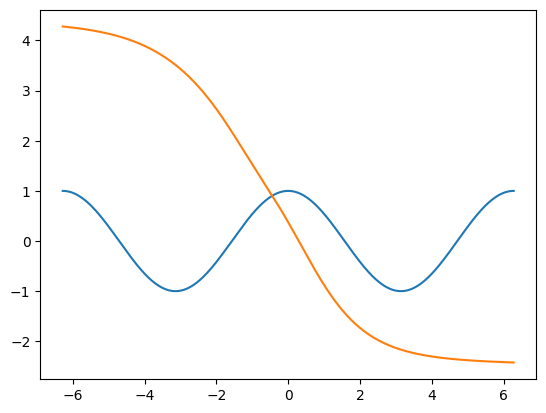

In [44]:
plt.plot(train_data, true_f(train_data))
plt.plot(train_data, model(train_data_tensor).detach().numpy())
plt.show()

하이퍼파라미터인 batch size, 학습률, epoch 수를 지정하겠습니다.

In [45]:
batch_size = 25
learning_rate = 0.01
loss_values = []
n_epochs = 1000

매 epoch마다 랜덤 batch 별 학습을 진행하기 위해서 batch를 먼저 정해주고, 각 batch에 대해 한 번에 학습을 진행하는 방식으로 학습시키겠습니다.

In [46]:
for epoch in range(n_epochs):
    idxs = np.arange(len(train_data))
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(train_data) // batch_size):
      batch_indices = idxs[batch_cnt * batch_size : (batch_cnt +1) * batch_size]

      batch = train_data[batch_indices]
      truth = true_f(batch)

      batch_tensor = torch.tensor(batch, dtype = torch.float32)
      truth_tensor = torch.tensor(truth, dtype = torch.float32)

      prediction = model(batch_tensor)
      loss = loss_func(prediction, truth_tensor)

      model.zero_grad()
      loss.backward()
      gradient_step(model.parameters(), learning_rate)

    loss_values.append(loss.detach().clone().numpy())
    print(f'Epoch {epoch + 1}')
    print(f'loss {loss}')

Epoch 1
loss 0.6680377125740051
Epoch 2
loss 0.4920150637626648
Epoch 3
loss 0.4668445587158203
Epoch 4
loss 0.29422858357429504
Epoch 5
loss 0.6199882626533508
Epoch 6
loss 0.38829174637794495
Epoch 7
loss 0.3851354718208313
Epoch 8
loss 0.4336620271205902
Epoch 9
loss 0.4431634545326233
Epoch 10
loss 0.2933429777622223
Epoch 11
loss 0.401848703622818
Epoch 12
loss 0.3112744092941284
Epoch 13
loss 0.38249993324279785
Epoch 14
loss 0.3897913694381714
Epoch 15
loss 0.2833174467086792
Epoch 16
loss 0.40383586287498474
Epoch 17
loss 0.3264504671096802
Epoch 18
loss 0.33657801151275635
Epoch 19
loss 0.3664705157279968
Epoch 20
loss 0.3138394057750702
Epoch 21
loss 0.32228004932403564
Epoch 22
loss 0.2328234165906906
Epoch 23
loss 0.33563101291656494
Epoch 24
loss 0.36608514189720154
Epoch 25
loss 0.3028751611709595
Epoch 26
loss 0.29594263434410095
Epoch 27
loss 0.389277845621109
Epoch 28
loss 0.2624471187591553
Epoch 29
loss 0.2022692710161209
Epoch 30
loss 0.3080216646194458
Epoch 31
los

TensorDataset과 DataLoader 기능을 쓰면 더 쉽게 batch를 나누고 섞을 수 있습니다.

* TensorDataset: 텐서 데이터셋을 생성하기 위한 클래스. 여러 개의 텐서를 하나의 데이터셋으로 묶을 수 있음
* DataLoader: 데이터셋을 로드하고, 배치 단위로 데이터를 반환하며, 셔플링과 병렬 처리를 지원하는 클래스

In [48]:
from torch.utils.data import DataLoader, TensorDataset

train_data_tensor = torch.tensor(train_data, dtype = torch.float32)
truth_tensor = torch.tensor(true_f(train_data), dtype = torch.float32)

dataset = TensorDataset(train_data_tensor, truth_tensor)
dataloader = DataLoader(dataset, batch_size = 25, shuffle = True)

모델을 다시 정의해서 학습시켜보겠습니다.

In [50]:
model = Model(num_neurons = 10)

loss_values = []

for epoch in range(n_epochs):
    for batch in dataloader:
      batch_tensor, truth_tensor = batch

      prediction = model(batch_tensor)
      loss = loss_func(prediction, truth_tensor)

      model.zero_grad()
      loss.backward()
      gradient_step(model.parameters(), learning_rate)

    loss_values.append(loss.detach().clone().numpy())
    print(f'Epoch {epoch + 1}')
    print(f'loss {loss}')


Epoch 1
loss 0.5840471386909485
Epoch 2
loss 0.494970440864563
Epoch 3
loss 0.3926229774951935
Epoch 4
loss 0.437107115983963
Epoch 5
loss 0.5047077536582947
Epoch 6
loss 0.5860359072685242
Epoch 7
loss 0.6061968207359314
Epoch 8
loss 0.5336782932281494
Epoch 9
loss 0.40641769766807556
Epoch 10
loss 0.5540607571601868
Epoch 11
loss 0.6394612193107605
Epoch 12
loss 0.45173484086990356
Epoch 13
loss 0.5963687300682068
Epoch 14
loss 0.5616387724876404
Epoch 15
loss 0.5447154641151428
Epoch 16
loss 0.5475081205368042
Epoch 17
loss 0.4949153661727905
Epoch 18
loss 0.656018853187561
Epoch 19
loss 0.5436235666275024
Epoch 20
loss 0.4411427974700928
Epoch 21
loss 0.514543890953064
Epoch 22
loss 0.4599606394767761
Epoch 23
loss 0.4117659628391266
Epoch 24
loss 0.5456869006156921
Epoch 25
loss 0.48147720098495483
Epoch 26
loss 0.45770594477653503
Epoch 27
loss 0.4792785942554474
Epoch 28
loss 0.39905601739883423
Epoch 29
loss 0.41003909707069397
Epoch 30
loss 0.4246205985546112
Epoch 31
loss 0.4

근사함수 모델 $F$가 함수 $f$와 얼마나 가까워졌는지 살펴보겠습니다.

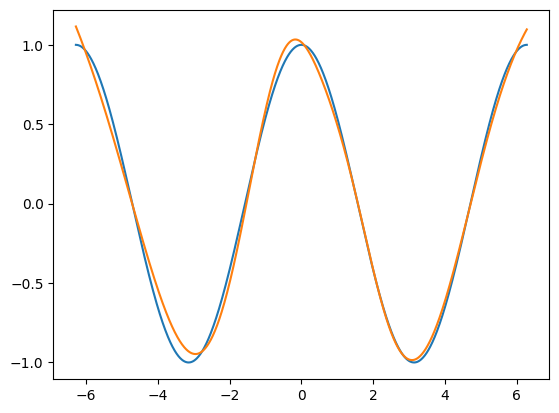

In [54]:
plt.plot(train_data, true_f(train_data))

model_output = model(train_data_tensor).detach().numpy()
plt.plot(train_data, model_output)
plt.show()

### 2.2. 학습 과정 관찰하기

위에서 학습시킨 model의 loss가 어떻게 변하는지 관찰해보겠습니다.

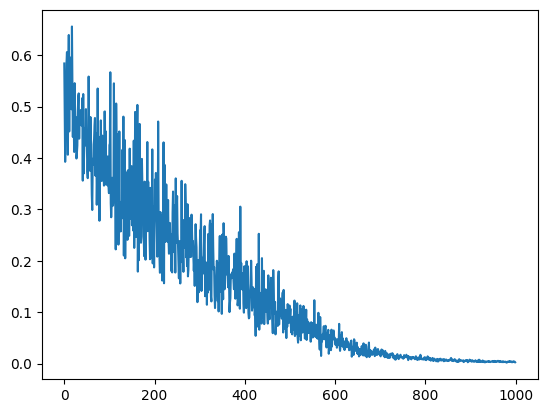

In [55]:
plt.plot(loss_values)

학습을 진행한 $N=10$개의 뉴런으로부터 얻는 각각의 결과값을 그래프로 나타내어 보겠습니다. 즉, $i=1, ..., N$의 N개의 뉴런에 대해 구간 $x \in [-2\pi, 2\pi]$에서 $\varphi(x \cdot w_{i} + b_{i})$의 그래프가 어떻게 나타나는지 그래프로 그려보겠습니다. 각 뉴런의 결과까지만 확인하는 것이므로 이 식에서 $v_i$는 미포함하겠습니다.

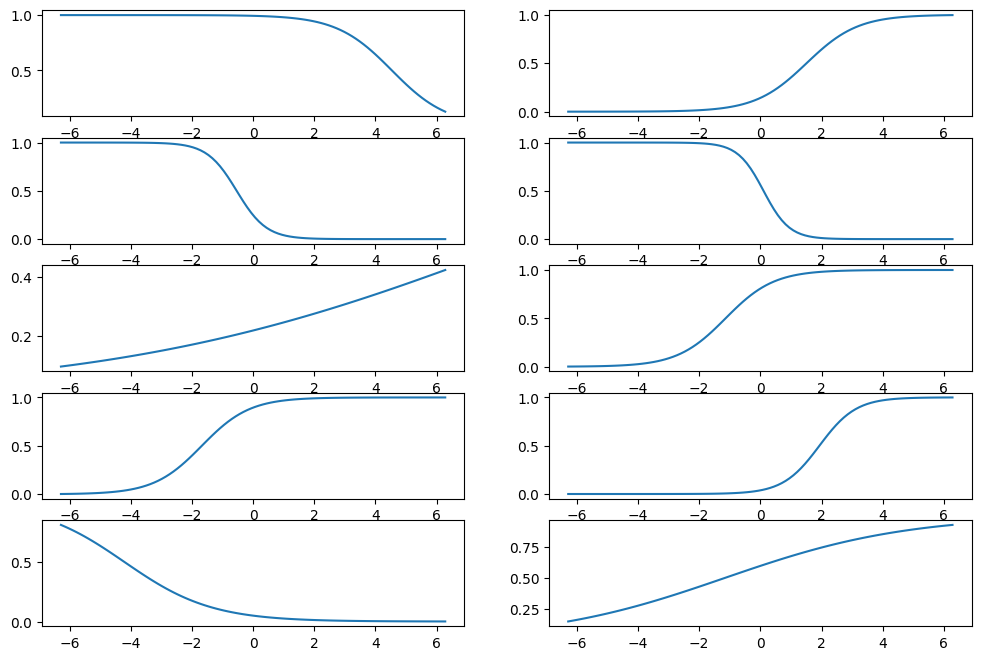

In [58]:
fig, axes = plt.subplots(5,2, figsize = (12, 8))
x = np.linspace(-2*np.pi, 2*np.pi, 100)

w,b,v = model.model_parameters

for ax, w_i, b_i in zip(axes.flatten(), w.flatten(), b.flatten()):
  x_tensor = torch.tensor(x,dtype = torch.float32)
  y = torch.sigmoid(x_tensor * w_i.item() + b_i.item())
  ax.plot(x,y.detach().numpy())

마지막으로 각 뉴런에서 얻어진 결과값에 $v_i$를 곱해준 값들을 하나의 그래프에 plot 하고, 이들을 모두 합한 것을 굵은 검은 점선으로 plot 해서 이 그래프의 모양이 함수 $f(x)=cos(x)$와 얼마나 가까운지 확인해보겠습니다.

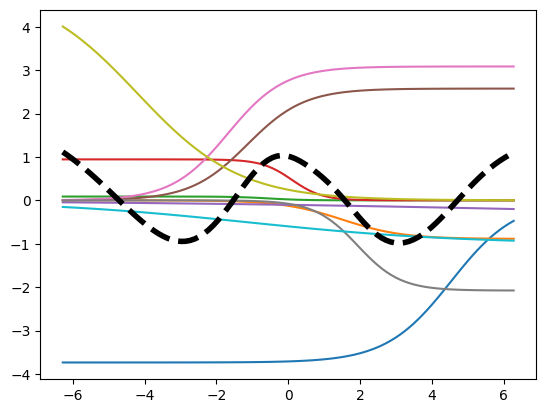

In [62]:
x_tensor = torch.tensor(x, dtype = torch.float32)
F = torch.zeros_like(x_tensor)

W, B, V = model.model_parameters

for w, b, v in zip(W.flatten(), B.flatten(), V.flatten()):
  y = v.item() * torch.sigmoid(x_tensor * w.item() + b.item())
  plt.plot(x, y.detach().numpy())
  F += y

plt.plot(x, F.detach().numpy(), color = 'black', ls = '--', lw = 4)